/tmp/ipykernel_656592/679256697.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Invalid values found in Current Loan Amount: 100000   NaN
100001   NaN
100002   NaN
100003   NaN
100004   NaN
          ..
100509   NaN
100510   NaN
100511   NaN
100512   NaN
100513   NaN
Name: Current Loan Amount, Length: 514, dtype: float64
Invalid values found in Credit Score: 1        NaN
4        NaN
7        NaN
11       NaN
15       NaN
          ..
100509   NaN
100510   NaN
100511   NaN
100512   NaN
100513   NaN
Name: Credit Score, Length: 19668, dtype: float64
Invalid values found in Annual Income: 1        NaN
4        NaN
7        NaN
11       NaN
15       NaN
          ..
100509   NaN
100510   NaN
100511   NaN
100512   NaN
100513   NaN
Name: Annual Income, Length: 19668, dtype: float64
Invalid values found in Monthly Debt: 100000   NaN
100001   NaN
100002   NaN
100003   NaN
100004   NaN
          ..
100509   NaN
100510   NaN
100511   NaN
100512   NaN
100513   NaN
Name: Monthly Debt, Length: 514, dtype: float64
Invalid values found in Years of Credit History: 100000   NaN
10

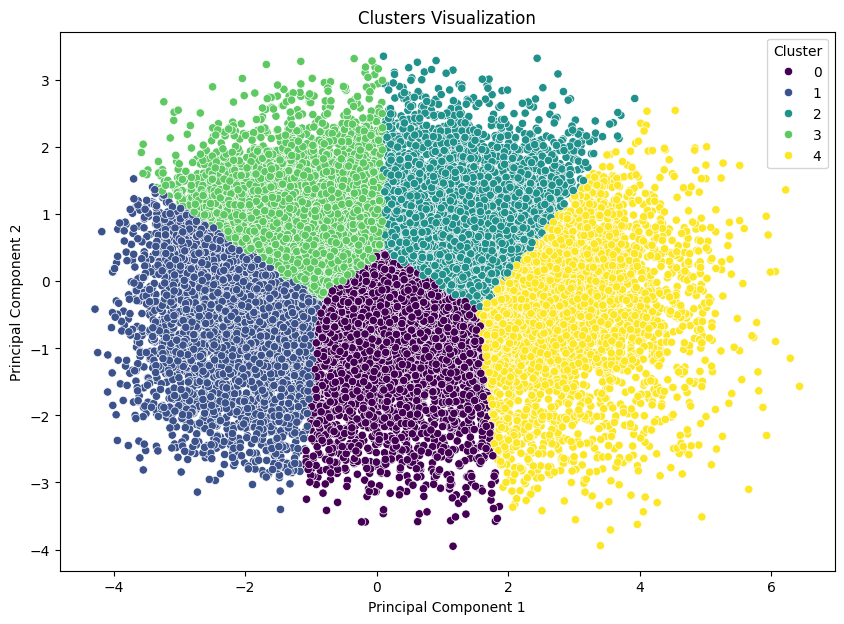


Cluster 0 Characteristics:
       Loan Status  Current Loan Amount        Term  Credit Score  \
count         6102          6102.000000        6102   6102.000000   
unique           3                  NaN           3           NaN   
top     Fully Paid                  NaN  Short Term           NaN   
freq          4315                  NaN        3951           NaN   
mean           NaN        323098.049820         NaN    717.034743   
std            NaN        139384.333237         NaN     12.710439   
min            NaN         21604.000000         NaN    681.000000   
25%            NaN        222266.000000         NaN    710.000000   
50%            NaN        322003.000000         NaN    724.000000   
75%            NaN        407561.000000         NaN    724.000000   
max            NaN        788480.000000         NaN    750.000000   

        Annual Income Years in current job Home Ownership             Purpose  \
count    6.102000e+03                 6102           6102     

/tmp/ipykernel_656592/679256697.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=raw_data, palette='viridis', ax=axes[i, 0])
/tmp/ipykernel_656592/679256697.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=raw_data, palette='viridis', ax=axes[i, 0])
/tmp/ipykernel_656592/679256697.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=raw_data, palette='viridis', ax=axes[i, 0])
/tmp/ipykernel_656592/679256697.py:114: FutureWarning: 

Passing `pale

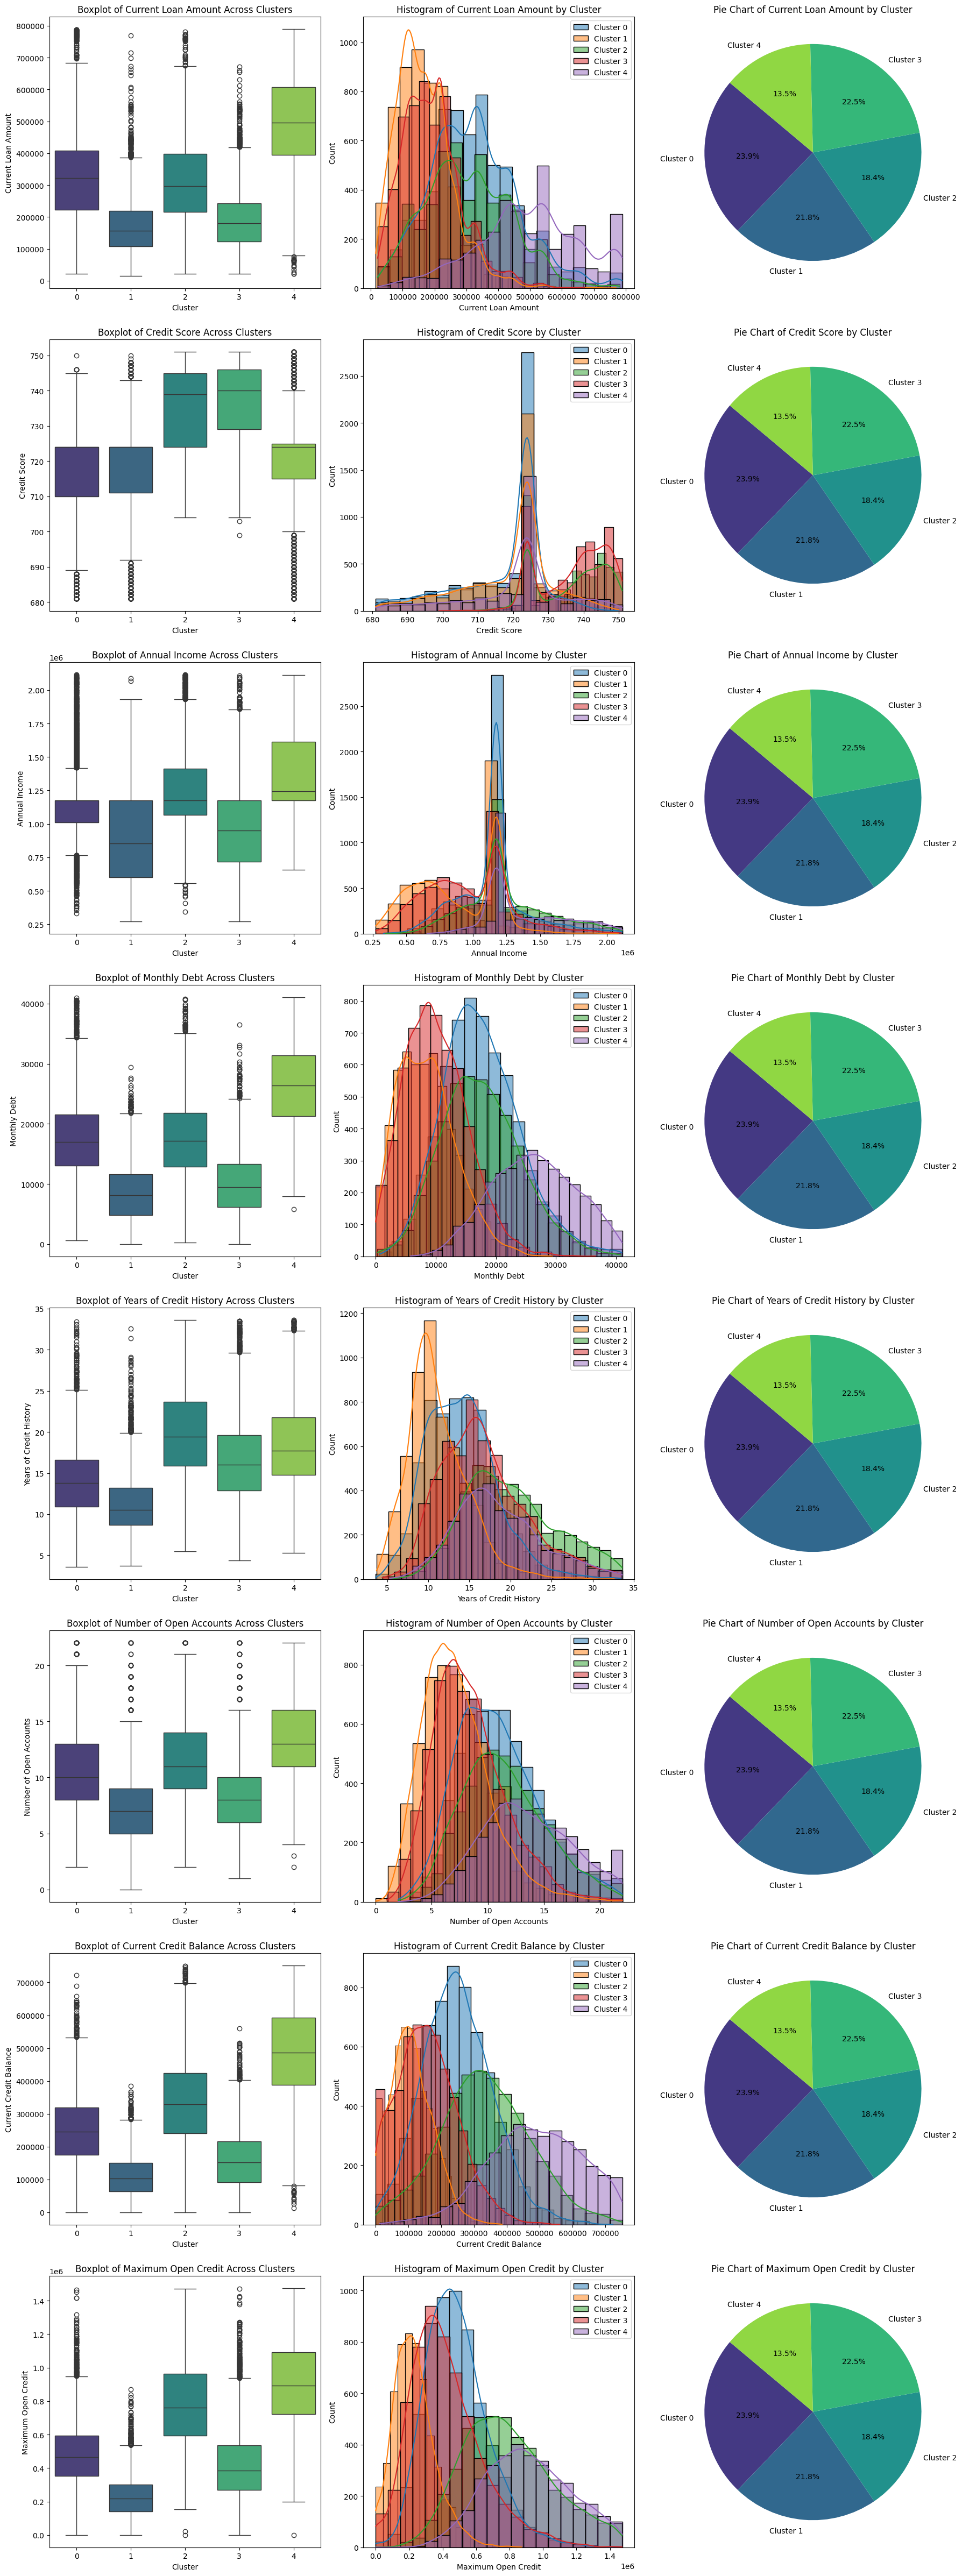

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Load the dataset
file_path = '../dataset/credit_train.csv'
df = pd.read_csv(file_path)

# Fix column data types
for col in df.select_dtypes(include=['object']).columns:
    try:
        # Attempt to convert numeric-looking strings to floats
        df[col] = pd.to_numeric(df[col], errors='ignore')
    except Exception as e:
        print(f"Error converting column {col}: {e}")

# Validate numerical columns
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    invalid_values = df[col][~df[col].apply(lambda x: np.isfinite(x))]
    if not invalid_values.empty:
        print(f"Invalid values found in {col}: {invalid_values}")
        df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(df[col].median())

# Handle missing values
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())
print("\nMissing values handled by filling with median.")

# Handle categorical columns
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].fillna('Unknown')
    df[col] = df[col].astype('category')
print("\nCategorical columns handled by filling with 'Unknown'.")

# Drop duplicate rows
df = df.drop_duplicates()
print("\nDuplicate rows dropped.")

# Drop unnecessary columns
if 'Loan ID' in df.columns and 'Customer ID' in df.columns:
    df = df.drop(columns=['Loan ID', 'Customer ID'])
    print("\nColumns 'Loan ID' and 'Customer ID' dropped.")

# Handle outliers using IQR
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print("\nOutliers handled using IQR method.")

# Select relevant features for clustering
selected_features = [
    'Current Loan Amount', 'Credit Score', 'Annual Income',
    'Monthly Debt', 'Years of Credit History',
    'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit'
]
df_selected = df[selected_features]

# Standardize the selected features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_selected)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
print(f"\nExplained Variance Ratio: {pca.explained_variance_ratio_}")

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)

# Calculate silhouette score
score = silhouette_score(pca_df.iloc[:, :-1], pca_df['Cluster'])
print(f"Silhouette Score: {score}")

# Visualize clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette='viridis')
plt.title("Clusters Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Display information about each cluster from raw data
raw_data = df.reset_index(drop=True)
raw_data['Cluster'] = pca_df['Cluster'].values

# Assign cluster labels to raw data and analyze clusters
for cluster_label in sorted(raw_data['Cluster'].unique()):
    cluster_data = raw_data[raw_data['Cluster'] == cluster_label]
    print(f"\nCluster {cluster_label} Characteristics:")
    print(cluster_data.describe(include='all'))

# Save raw data with cluster labels to a new CSV file
raw_data.to_csv('../dataset/credit_train_with_clusters.csv', index=False)
print("\nCluster labels added to raw data and saved to 'credit_train_with_clusters.csv'.")

# Visualize comparisons of clusters based on raw features
features_to_plot = selected_features
fig, axes = plt.subplots(len(features_to_plot), 3, figsize=(18, 6 * len(features_to_plot)))
for i, feature in enumerate(features_to_plot):
    # Boxplot
    sns.boxplot(x='Cluster', y=feature, data=raw_data, palette='viridis', ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot of {feature} Across Clusters")
    axes[i, 0].set_xlabel("Cluster")
    axes[i, 0].set_ylabel(feature)

    # Histogram
    for cluster_label in sorted(raw_data['Cluster'].unique()):
        sns.histplot(
            raw_data[raw_data['Cluster'] == cluster_label][feature],
            bins=20, kde=True, ax=axes[i, 1], label=f"Cluster {cluster_label}", alpha=0.5
        )
    axes[i, 1].set_title(f"Histogram of {feature} by Cluster")
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].legend()

    # Pie chart
    cluster_counts = raw_data.groupby('Cluster')[feature].count()
    axes[i, 2].pie(
        cluster_counts,
        labels=[f"Cluster {label}" for label in cluster_counts.index],
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(cluster_counts))
    )
    axes[i, 2].set_title(f"Pie Chart of {feature} by Cluster")

plt.tight_layout()
plt.show()
